In [2]:
# Import necessary libs
import warnings
warnings.filterwarnings("ignore")
import gc

import pandas as pd
import numpy as np
import string
import math
from tqdm.notebook import tqdm
tqdm.pandas()

from wordcloud import WordCloud

import xgboost
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import wordnet
from nltk.stem import PorterStemmer 
from nltk.tokenize import word_tokenize
#nltk.download('wordnet')
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
import scipy
from scipy.sparse import hstack

from sklearn.metrics import mean_squared_log_error
import pickle
import regex as re
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
train_df = pd.read_csv("Dataset/train.tsv",  sep='\t')
train_df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [4]:
# LOADING THE TEST DATASET
test_df  = pd.read_csv("Dataset/test.tsv",delimiter="\t",index_col=["test_id"])
test_df.head()

,name,item_condition_id,category_name,brand_name,shipping,item_description
test_id,,,,,,
0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7
1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...
3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and pe...
4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,Rediscovering life after the loss of a loved o...


## EDA

### Basic Stats

In [5]:
'''GETTING THE SHAPE OF THE DATASET'''
train_df.shape

(1482535, 8)

In [6]:
test_df.shape

(693359, 6)

In [7]:
'''GETTING THE BASIC INFO ABOUT THE DATASET'''
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482529 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB


In [8]:
# Checking number of null values
train_df.isnull().sum(axis=0)

train_id                  0
name                      0
item_condition_id         0
category_name          6327
brand_name           632682
price                     0
shipping                  0
item_description          6
dtype: int64

In [9]:
total_rows = train_df.shape[0]
null_values = train_df.isnull().sum(axis=0)
print("Null brands", round(null_values['brand_name']/total_rows*100,2),'%')
print("Null categories", round(null_values['category_name']/total_rows*100,2),'%')
print("Null item description", round(null_values['item_description']/total_rows*100,4),'%')

Null brands 42.68 %
Null categories 0.43 %
Null item description 0.0004 %


**Observation :**
We can observe that out of all the features present category_name,"brand_name" and "item_description" contains some null values.

#### 1. Analyzing Price (Target column)
Plotting the PDF of the price column gives us the following distribution,

In [10]:
train_df['price'].describe()

count    1.482535e+06
mean     2.673752e+01
std      3.858607e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

<Axes: xlabel='price', ylabel='Density'>

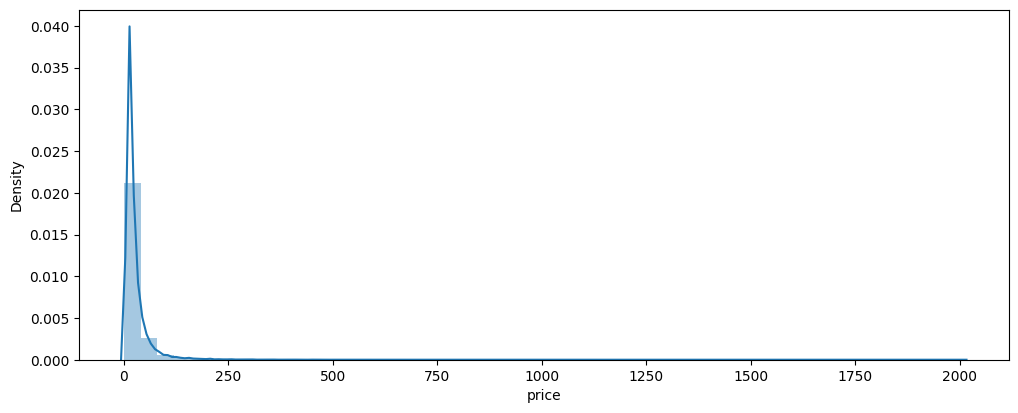

In [11]:
# Plot the distribution of the prices
plt.figure(figsize=(12,10))
plt.subplot(211)
sns.distplot(train_df['price'])

We can see that the price distribution is highly skewed. From the above graph we can see that most of the prices are between 0 to 250. There are very few items which are priced above 250.
We will get more clear picture of the price distribution, when we check the prices at several percentiles.

In [12]:
#print 0 to 100 percentile values with step size of 10 for train data duration. 
for i in range(0,101,10):
    print(i,"th percentile is",np.percentile(train_df['price'].values, i))

0 th percentile is 0.0
10 th percentile is 7.0
20 th percentile is 10.0
30 th percentile is 12.0
40 th percentile is 14.0
50 th percentile is 17.0
60 th percentile is 20.0
70 th percentile is 26.0
80 th percentile is 34.0
90 th percentile is 51.0
100 th percentile is 2009.0


In [13]:
##print 90 to 100 percentile values with step size of 1. 
for i in range(90,101):
    print(i,"th percentile is",np.percentile(train_df['price'].values, i))

90 th percentile is 51.0
91 th percentile is 55.0
92 th percentile is 58.0
93 th percentile is 62.0
94 th percentile is 67.0
95 th percentile is 75.0
96 th percentile is 85.0
97 th percentile is 99.0
98 th percentile is 122.0
99 th percentile is 170.0
100 th percentile is 2009.0


In [14]:
# printing 99 to 100 percentile values with step size of 0.1
for i in [99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]:
    print(i,"th percentile is",np.percentile(train_df['price'].values, i))

99.1 th percentile is 180.0
99.2 th percentile is 189.0
99.3 th percentile is 200.0
99.4 th percentile is 210.0
99.5 th percentile is 230.3300000000745
99.6 th percentile is 256.0
99.7 th percentile is 286.0
99.8 th percentile is 340.0
99.9 th percentile is 450.0
100 th percentile is 2009.0


In [15]:
print("Number of products with price >170 =",len(train_df[train_df['price']>170]['price']))

Number of products with price >170 = 14741


From the prices at the above percentiles, we can see that 99% of the prices are less that 170. The higher prices are outliers but they are not anomolies. Now, there are two things that can be done.  

1). We discard the outliers and our model never learns to predict higher prices.
2). We do not discard the outliers and keep them in our training dataset, and our model learns the higher priced products too. BUT... this would hurt the overall model performance, because after all we are considering outliers in our training.  


My suggestion would be to take option 2.   
We can keep the higher priced products, but as most of the products are lower priced, we can use some kind of metric that would help the model learn the lower priced products more than the overpriced ones, but not totally discarding the higher priced products.  
Here our metric RMSLE comes to the rescue. This metric is typically used when the data is highly skewed (especially to the right, like in our case). This is because of its log operation, and its resultant mathematical properties like sacle invariance and robustness to outliers, to name a few.

**Applying log transform on the price**

<Axes: xlabel='log_prices', ylabel='Density'>

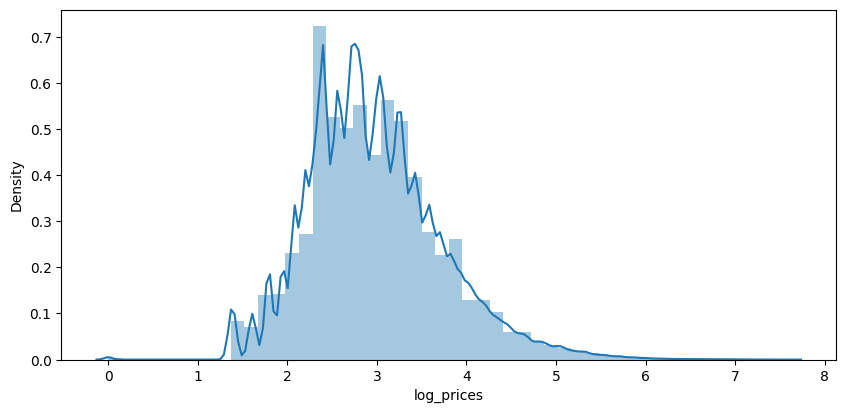

In [16]:
# Add a small constant to avoid taking the log of zero
small_constant = 1
train_df['log_prices'] = np.log(train_df['price'] + small_constant)


plt.figure(figsize=(10,10))
plt.subplot(211)
sns.distplot(train_df['log_prices'])

#### 2. Analyzing Shipping

Shipping 0 (Buyer Shipping) = 55.27 %
Shipping 1 (Seller Shipping) = 44.73 %


Text(0, 0.5, 'Number of products')

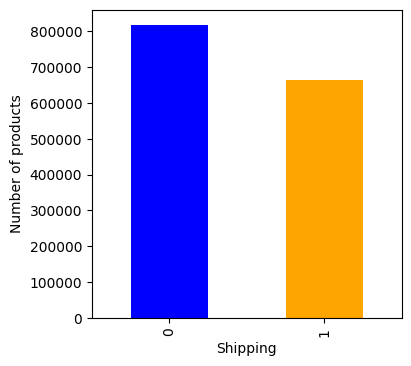

In [17]:
total_rows = train_df.shape[0]
shipping_counts = train_df['shipping'].value_counts()
print("Shipping 0 (Buyer Shipping) =", round(shipping_counts[0]/total_rows*100,2),'%')
print("Shipping 1 (Seller Shipping) =", round(shipping_counts[1]/total_rows*100,2),'%')
ax = train_df['shipping'].value_counts().plot.bar(color=['blue','orange'], figsize=(4,4))
ax.set_xlabel("Shipping")
ax.set_ylabel("Number of products")

No big variation is observed in the number of items sold with seller shipping (1) or buyer shipping (0). However, the number of items where the seller pays the shipping is less than those where the buyer pays for it.

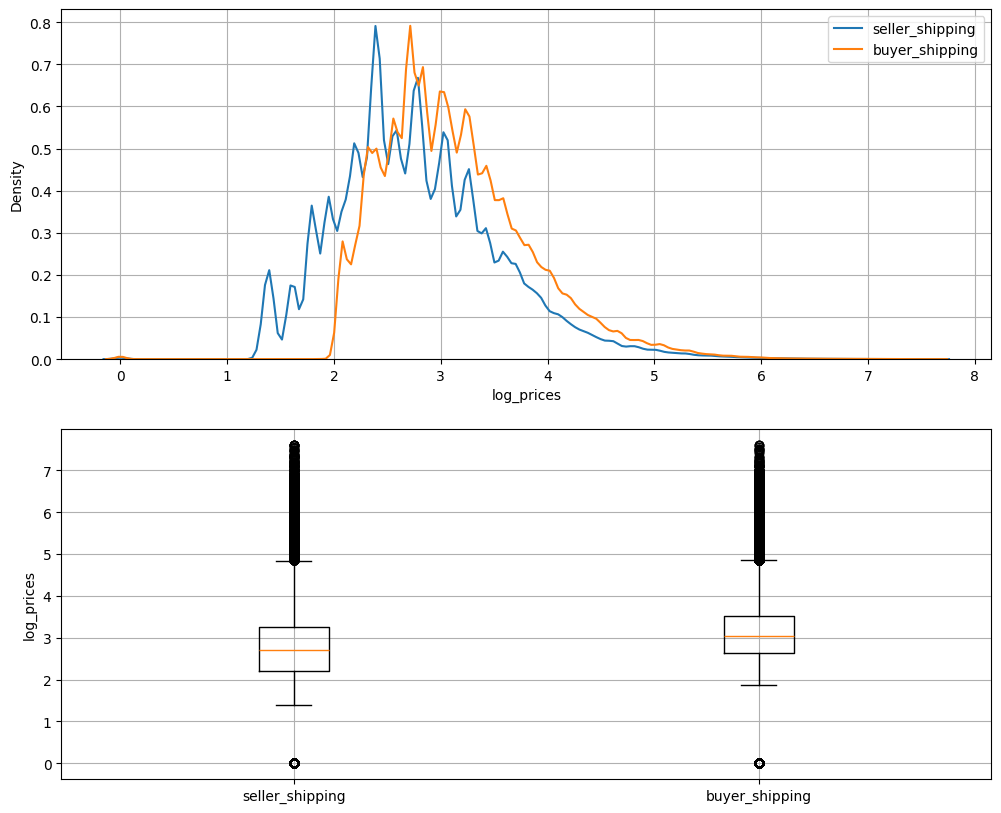

In [18]:
seller_shipping = train_df[train_df['shipping']==1]['log_prices']
#seller_shipping = seller_shipping[seller_shipping<150]
buyer_shipping = train_df[train_df['shipping']==0]['log_prices']
#buyer_shipping = buyer_shipping[buyer_shipping<150]
plt.figure(figsize=(12,10))
plt.subplot(211)
ax = sns.distplot(seller_shipping, hist=False, label="seller_shipping")
ax = sns.distplot(buyer_shipping, hist=False, label="buyer_shipping")
h,l = ax.get_legend_handles_labels()
ax.legend(h, l)
plt.grid()

plt.subplot(212)
plt.boxplot([seller_shipping, buyer_shipping])
plt.xticks([1,2],('seller_shipping','buyer_shipping'))
plt.ylabel('log_prices')
plt.grid()
plt.show()

In [19]:
## Seller pays for the items those are lesser than 1.8 as per in the graph.
## Taking antilog we get price as 6
np.exp(1.8)

6.0496474644129465

#### 3. Analyzing Item Condition

Condition 1 = 43.21 %
Condition 2 = 25.33 %
Condition 3 = 29.15 %
Condition 4 = 2.16 %
Condition 5 = 0.16 %


<Axes: xlabel='item_condition_id'>

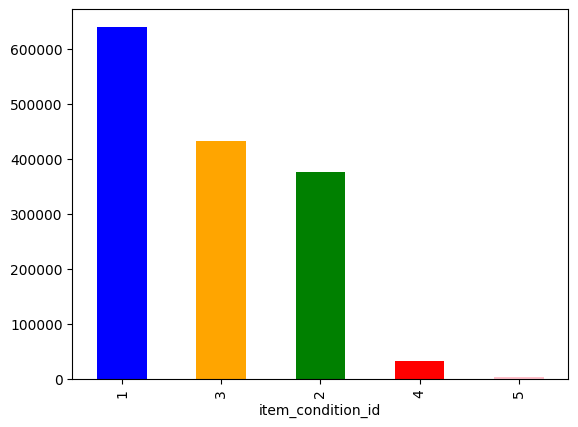

In [20]:
total_rows = train_df.shape[0]
categories_counts = train_df['item_condition_id'].value_counts()
print("Condition 1 =", round(categories_counts[1]/total_rows*100,2),'%')
print("Condition 2 =", round(categories_counts[2]/total_rows*100,2),'%')
print("Condition 3 =", round(categories_counts[3]/total_rows*100,2),'%')
print("Condition 4 =", round(categories_counts[4]/total_rows*100,2),'%')
print("Condition 5 =", round(categories_counts[5]/total_rows*100,2),'%')

train_df['item_condition_id'].value_counts().plot.bar(color=['blue','orange','green','red','pink'])

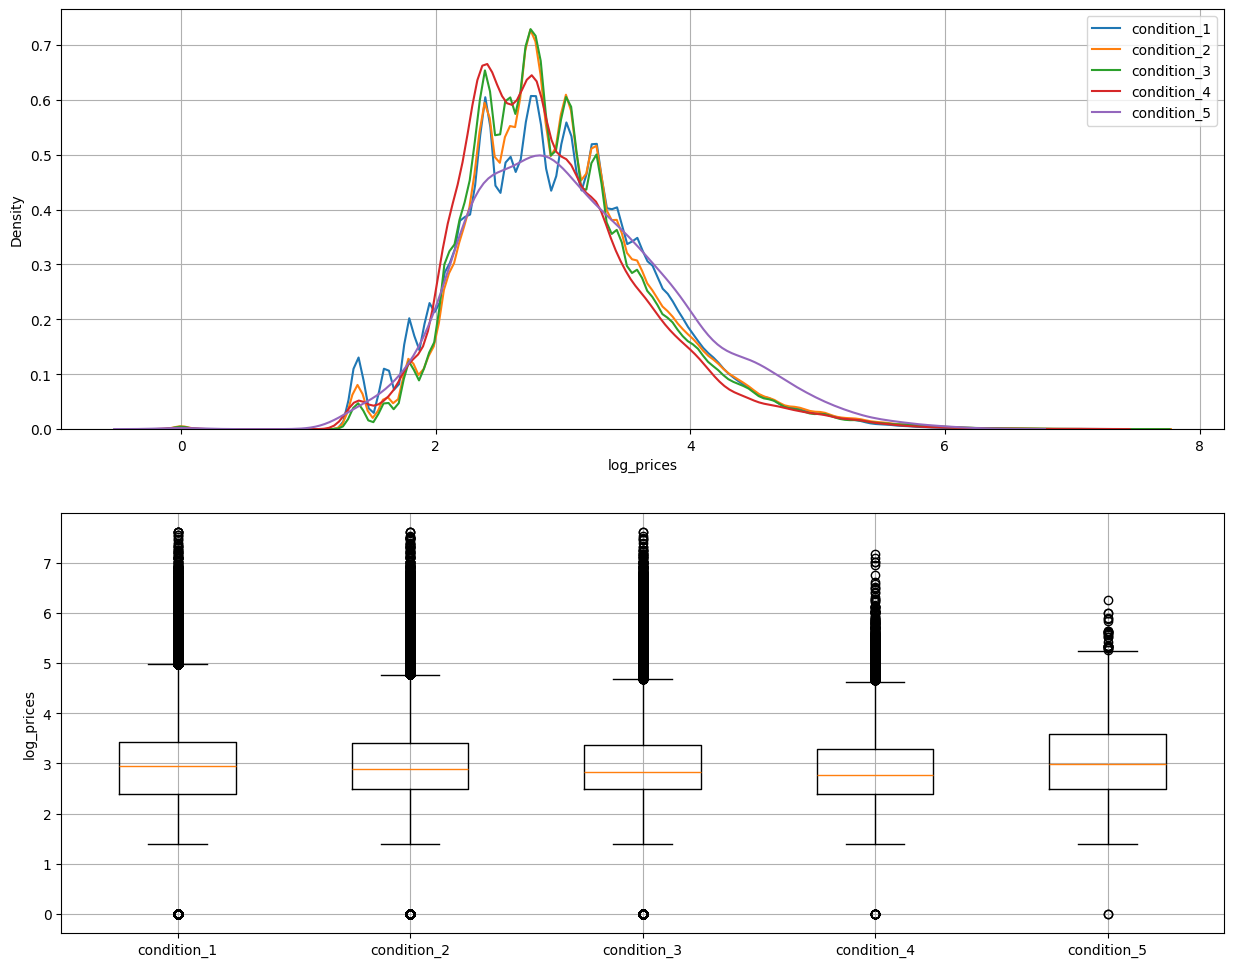

In [21]:
condition_1 = train_df[train_df['item_condition_id']==1]['log_prices']
#condition_1 = condition_1[condition_1<150]

condition_2 = train_df[train_df['item_condition_id']==2]['log_prices']
#condition_2 = condition_2[condition_2<150]

condition_3 = train_df[train_df['item_condition_id']==3]['log_prices']
#condition_3 = condition_3[condition_3<150]

condition_4 = train_df[train_df['item_condition_id']==4]['log_prices']
#condition_4 = condition_4[condition_4<150]

condition_5 = train_df[train_df['item_condition_id']==5]['log_prices']
#condition_5 = condition_5[condition_5<150]

plt.figure(figsize=(15,12))
plt.subplot(211)
ax = sns.distplot(condition_1, hist=False, label="condition_1")
ax = sns.distplot(condition_2, hist=False, label="condition_2")
ax = sns.distplot(condition_3, hist=False, label="condition_3")
ax = sns.distplot(condition_4, hist=False, label="condition_4")
ax = sns.distplot(condition_5, hist=False, label="condition_5")
h,l = ax.get_legend_handles_labels()
ax.legend(h, l)
plt.grid()

plt.subplot(212)
plt.boxplot([condition_1, condition_2, condition_3, condition_4, condition_5])
plt.xticks([1,2,3,4,5],('condition_1', 'condition_2', 'condition_3', 'condition_4', 'condition_5'))
plt.ylabel('log_prices')

plt.grid()
plt.show()

We can say that the prices are evenly spreaded for each of the item condition category. This overlap can make the model indecisive. As a result this feature can be considered for some feature engineering hack.

We can see that price vs condition graph does not provide much of a variation which causes it to be a indecisive feature. Hence we can use this feature for feature engineering

#### 4. Analyzing Item Name

We can see that most of the OP (original poster) are mentioning the brand names and the name of product in the item name section. We can see that they are also highlighting the free shipping info in this section, in order to attract the buyers.   

As seen earlier, there are a lot of missing values in the brand name column. So, we can try some feature engineering hack to guess the missing brand name from the item name.

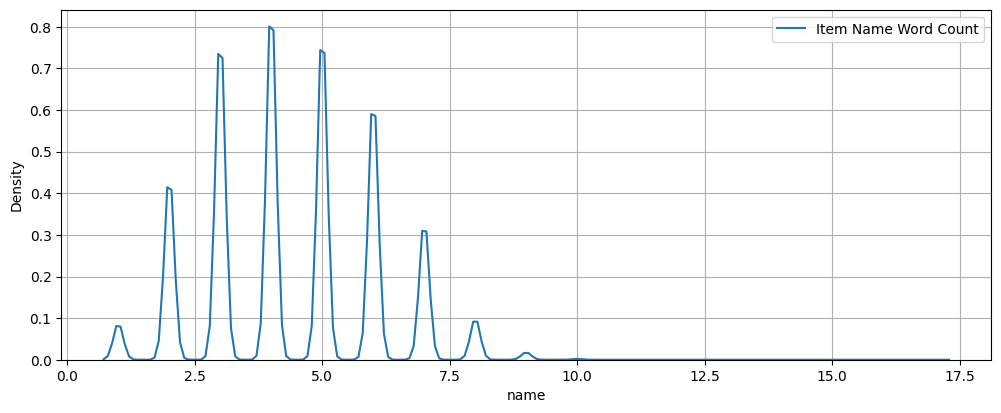

In [22]:
# Analyse word count in description
word_counts = train_df['name'].str.split().str.len()
plt.figure(figsize=(12,10))
plt.subplot(211)
ax = sns.distplot(word_counts, hist=False, label="Item Name Word Count")
h,l = ax.get_legend_handles_labels()
ax.legend(h, l)
plt.grid()
plt.show()

We can see that most of the products have their name section filled with the word count within the range of ~2 to 7 words.

#### 5. Analyzing Item Description

We can see that most of the OP (original poster) are using the words which describes the condition of the product like 'brand new', 'good condition', 'worn out'etc. We can use this info to do sentiment analysis on it, and add the sentiment scores as one of the features in the dataset. We can see that they are highlighting the shipping details in the description like 'free shipping'. They are also mentioning the brand names in the description.

We can see that most of the products have their description section filled with the word count within the range of ~1 to 50 words.
It is no surprise to see this distribution similar to log-normal distribution. So, we can use the standardized word length of the descriptions as one of our features.

#### 6. Analysing Brand Name

In [23]:
print("Number of unique brand names=",len(list(train_df['brand_name'].unique())))

Number of unique brand names= 4810


<Axes: title={'center': 'Top 50 brand names'}, xlabel='brand_name'>

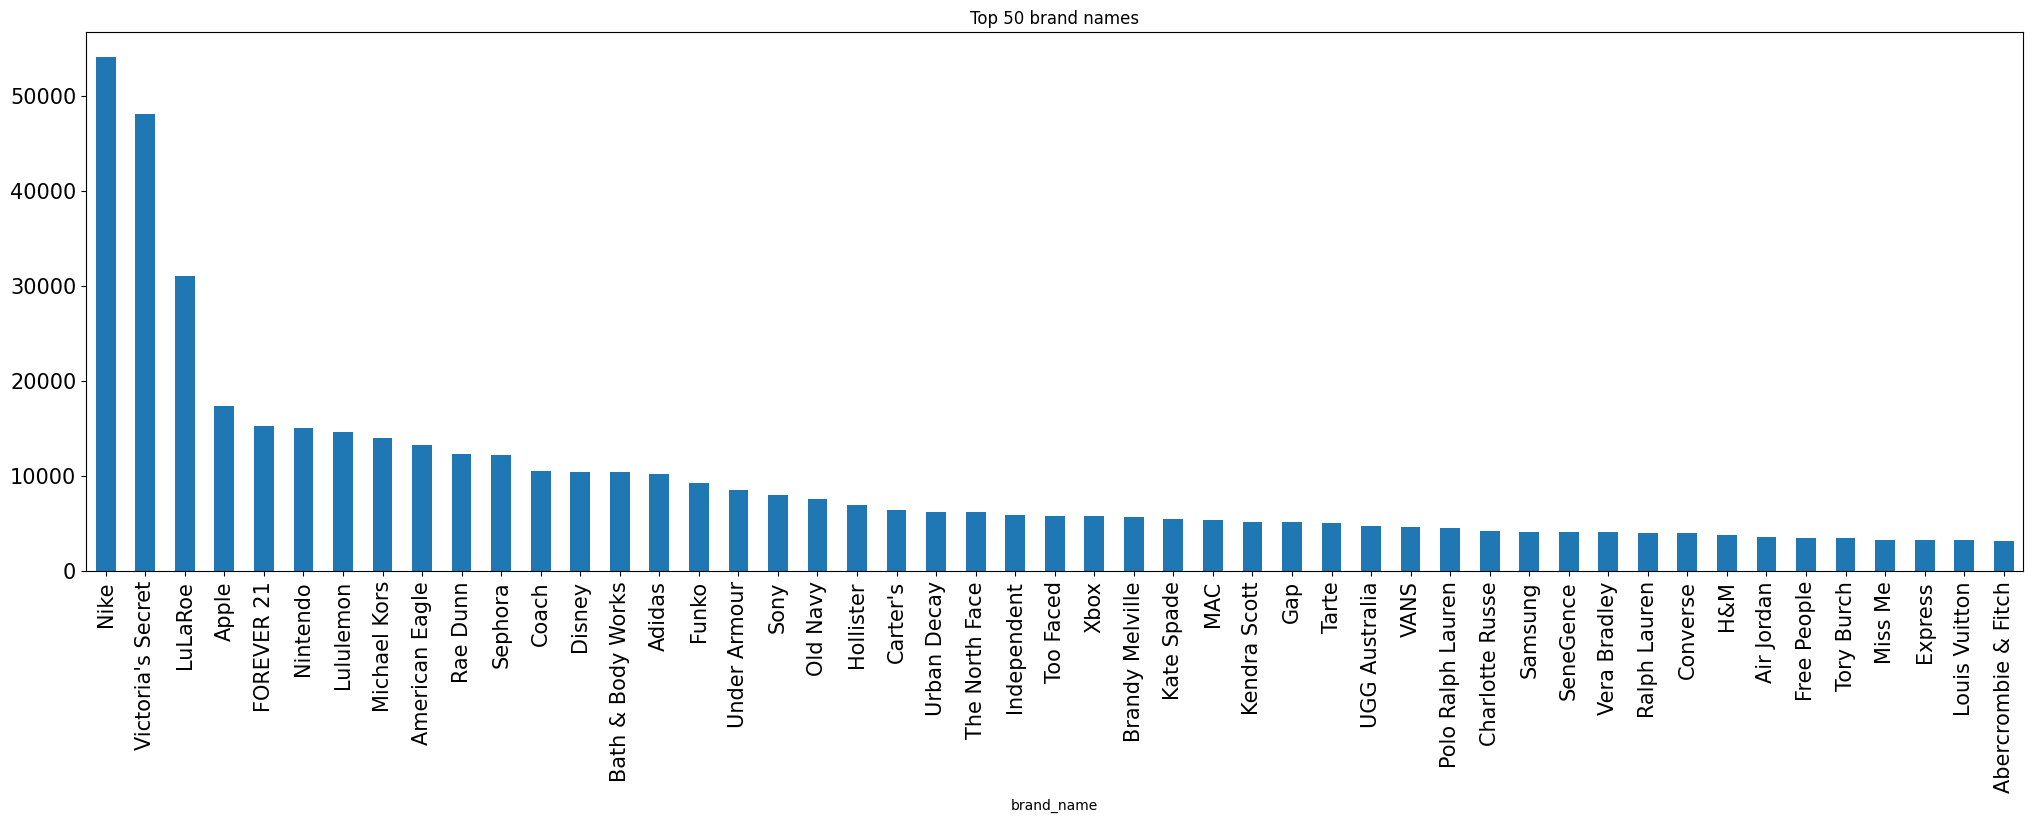

In [24]:
train_df['brand_name'].value_counts()[1:50].plot(kind='bar', figsize=(25,7), title="Top 50 brand names", fontsize=15)

There are 4810 unique brand names. We can see that in the top 50 most mentioned brands, most of them are apperels and some are electronics.

#### 7. Analysing Categories

In [25]:
def split_cat(text):
    """
    This function separated the categories into its three parts. Main category, sub-category 1 and sub-category 2
    """
    try: 
        return text.split("/")
    except: 
        return ("No Label", "No Label", "No Label")

train_df['general_cat'], train_df['subcat_1'], train_df['subcat_2'] = zip(*train_df['category_name'].apply(lambda x: split_cat(x)))
train_df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,log_prices,general_cat,subcat_1,subcat_2
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,2.397895,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,3.970292,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,2.397895,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,3.583519,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,3.806662,Women,Jewelry,Necklaces


In [26]:
print("No of unique values in main category: ",train_df['general_cat'].nunique())
print("No of unique values in Sub_category1: ",train_df['subcat_1'].nunique())
print("No of unique values in Sub_category2: ",train_df['subcat_2'].nunique())

No of unique values in main category:  11
No of unique values in Sub_category1:  114
No of unique values in Sub_category2:  871


In [27]:
train_df['general_cat'].value_counts()

general_cat
Women                     664385
Beauty                    207828
Kids                      171689
Electronics               122690
Men                        93680
Home                       67871
Vintage & Collectibles     46530
Other                      45351
Handmade                   30842
Sports & Outdoors          25342
No Label                    6327
Name: count, dtype: int64

In [28]:
total_rows = train_df.shape[0]
general_cat_counts = train_df['general_cat'].value_counts()
print("Women =\t", round(general_cat_counts['Women']/total_rows*100,2),'%')
print("Beauty = \t", round(general_cat_counts['Beauty']/total_rows*100,2),'%')
print("Kids =\t", round(general_cat_counts['Kids']/total_rows*100,4),'%')
print("Electronics =\t", round(general_cat_counts['Electronics']/total_rows*100,4),'%')
print("Men =\t", round(general_cat_counts['Men']/total_rows*100,4),'%')
print("Home =\t", round(general_cat_counts['Home']/total_rows*100,4),'%')
print("Vintage & Collectibles =\t", round(general_cat_counts['Vintage & Collectibles']/total_rows*100,4),'%')
print("Other =\t", round(general_cat_counts['Other']/total_rows*100,4),'%')
print("Handmade =", round(general_cat_counts['Handmade']/total_rows*100,4),'%')
print("Sports & Outdoors =\t", round(general_cat_counts['Sports & Outdoors']/total_rows*100,4),'%')
print("No Label =", round(general_cat_counts['No Label']/total_rows*100,4),'%')

Women =	 44.81 %
Beauty = 	 14.02 %
Kids =	 11.5808 %
Electronics =	 8.2757 %
Men =	 6.3189 %
Home =	 4.578 %
Vintage & Collectibles =	 3.1385 %
Other =	 3.059 %
Handmade = 2.0804 %
Sports & Outdoors =	 1.7094 %
No Label = 0.4268 %


In [29]:
from prettytable import PrettyTable

pt = PrettyTable()
pt.field_names = ["General Category", "Percentage"]

pt.add_row(['Women','44.81 %'])
pt.add_row(['Beauty','14.02 %'])
pt.add_row(['Kids','11.5808 %'])
pt.add_row(['Electronics','8.2757 %'])
pt.add_row(['Men','6.3189 %'])
pt.add_row(['Home','4.578 %'])
pt.add_row(['Vintage & Collectibles','3.1385 %'])
pt.add_row(['Other','3.059 %'])
pt.add_row(['Handmade','2.0804 %'])
pt.add_row(['Sports & Outdoors','1.7094 %'])
pt.add_row(['No Label','0.4268 %'])

print(pt)

+------------------------+------------+
|    General Category    | Percentage |
+------------------------+------------+
|         Women          |  44.81 %   |
|         Beauty         |  14.02 %   |
|          Kids          | 11.5808 %  |
|      Electronics       |  8.2757 %  |
|          Men           |  6.3189 %  |
|          Home          |  4.578 %   |
| Vintage & Collectibles |  3.1385 %  |
|         Other          |  3.059 %   |
|        Handmade        |  2.0804 %  |
|   Sports & Outdoors    |  1.7094 %  |
|        No Label        |  0.4268 %  |
+------------------------+------------+


<Axes: title={'center': 'Top main categories'}, xlabel='general_cat'>

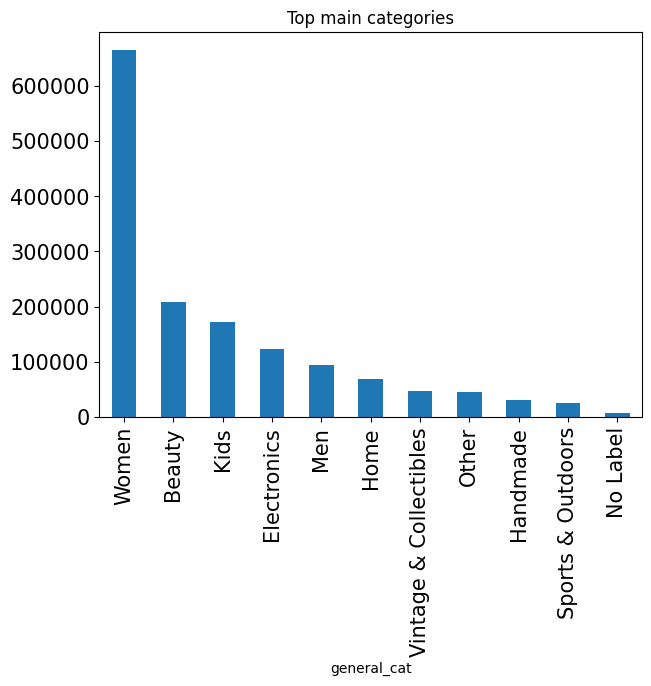

In [30]:
train_df['general_cat'].value_counts().plot(kind='bar', figsize=(7,5), title="Top main categories", fontsize=15)

<Axes: title={'center': 'Top 20 subcat_1'}, xlabel='subcat_1'>

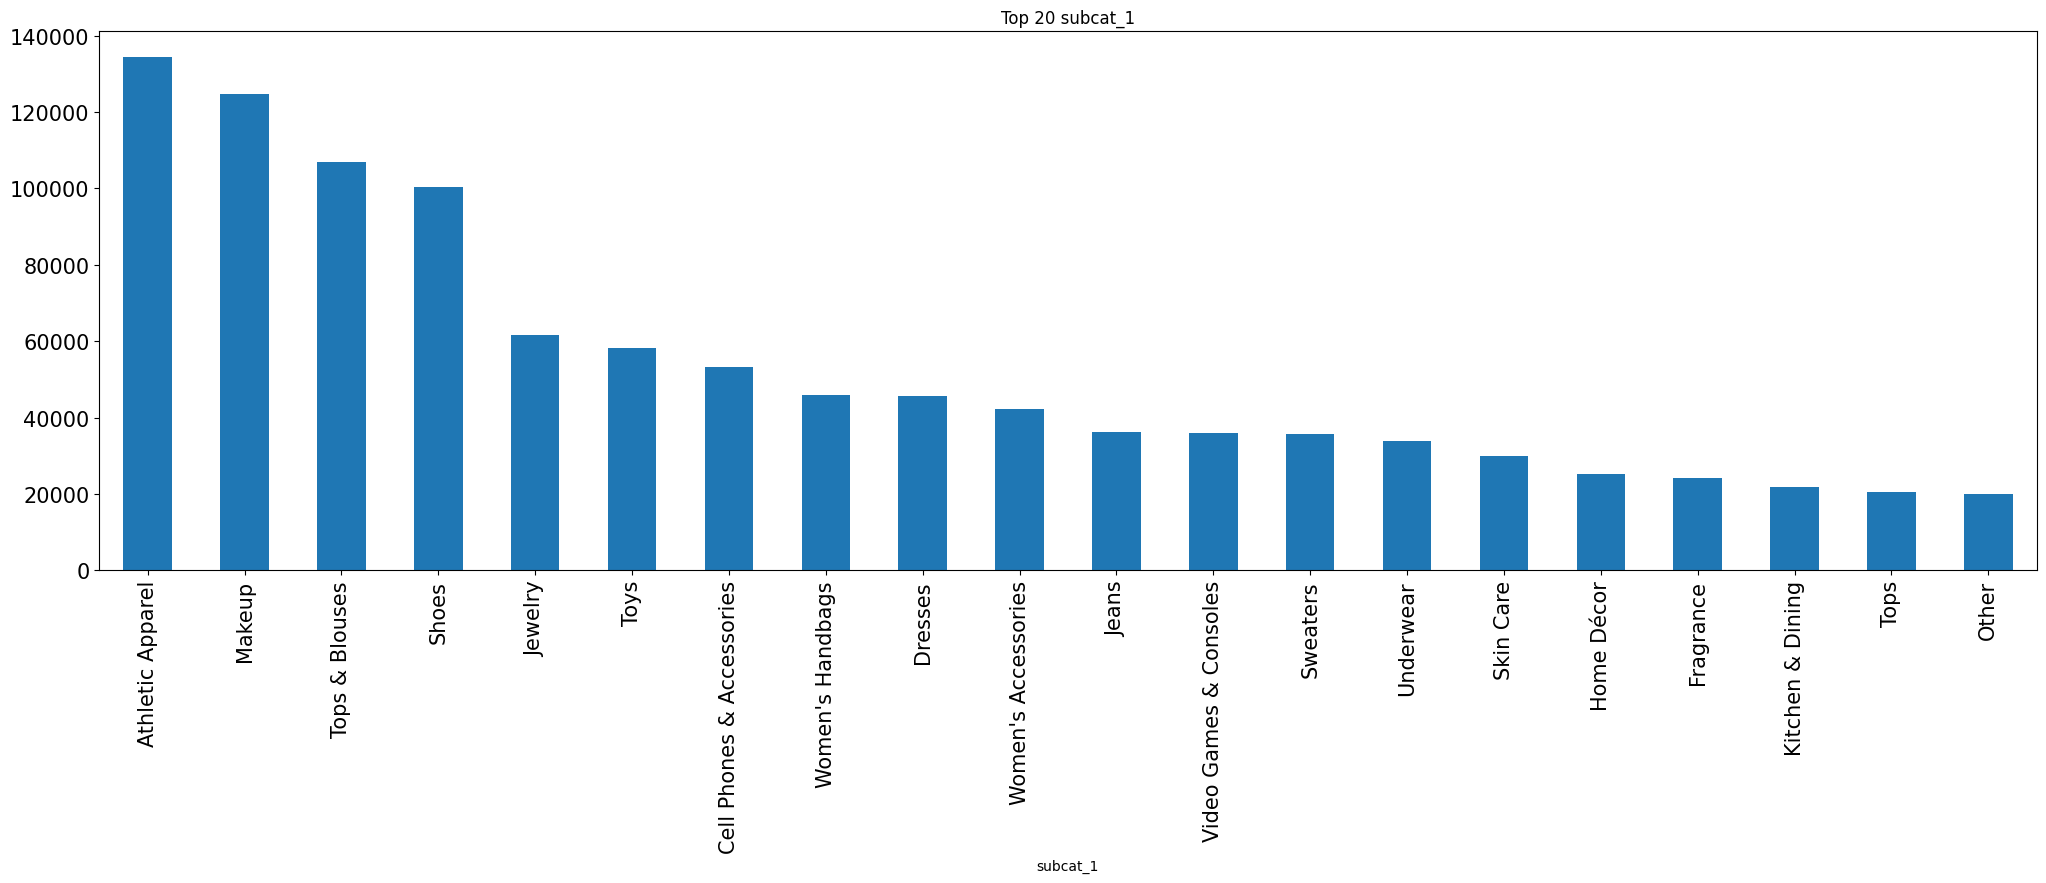

In [31]:
train_df['subcat_1'].value_counts()[:20].plot(kind='bar', figsize=(25,7), title="Top 20 subcat_1", fontsize=15)

<Axes: title={'center': 'Top 20 subcat_2'}, xlabel='subcat_2'>

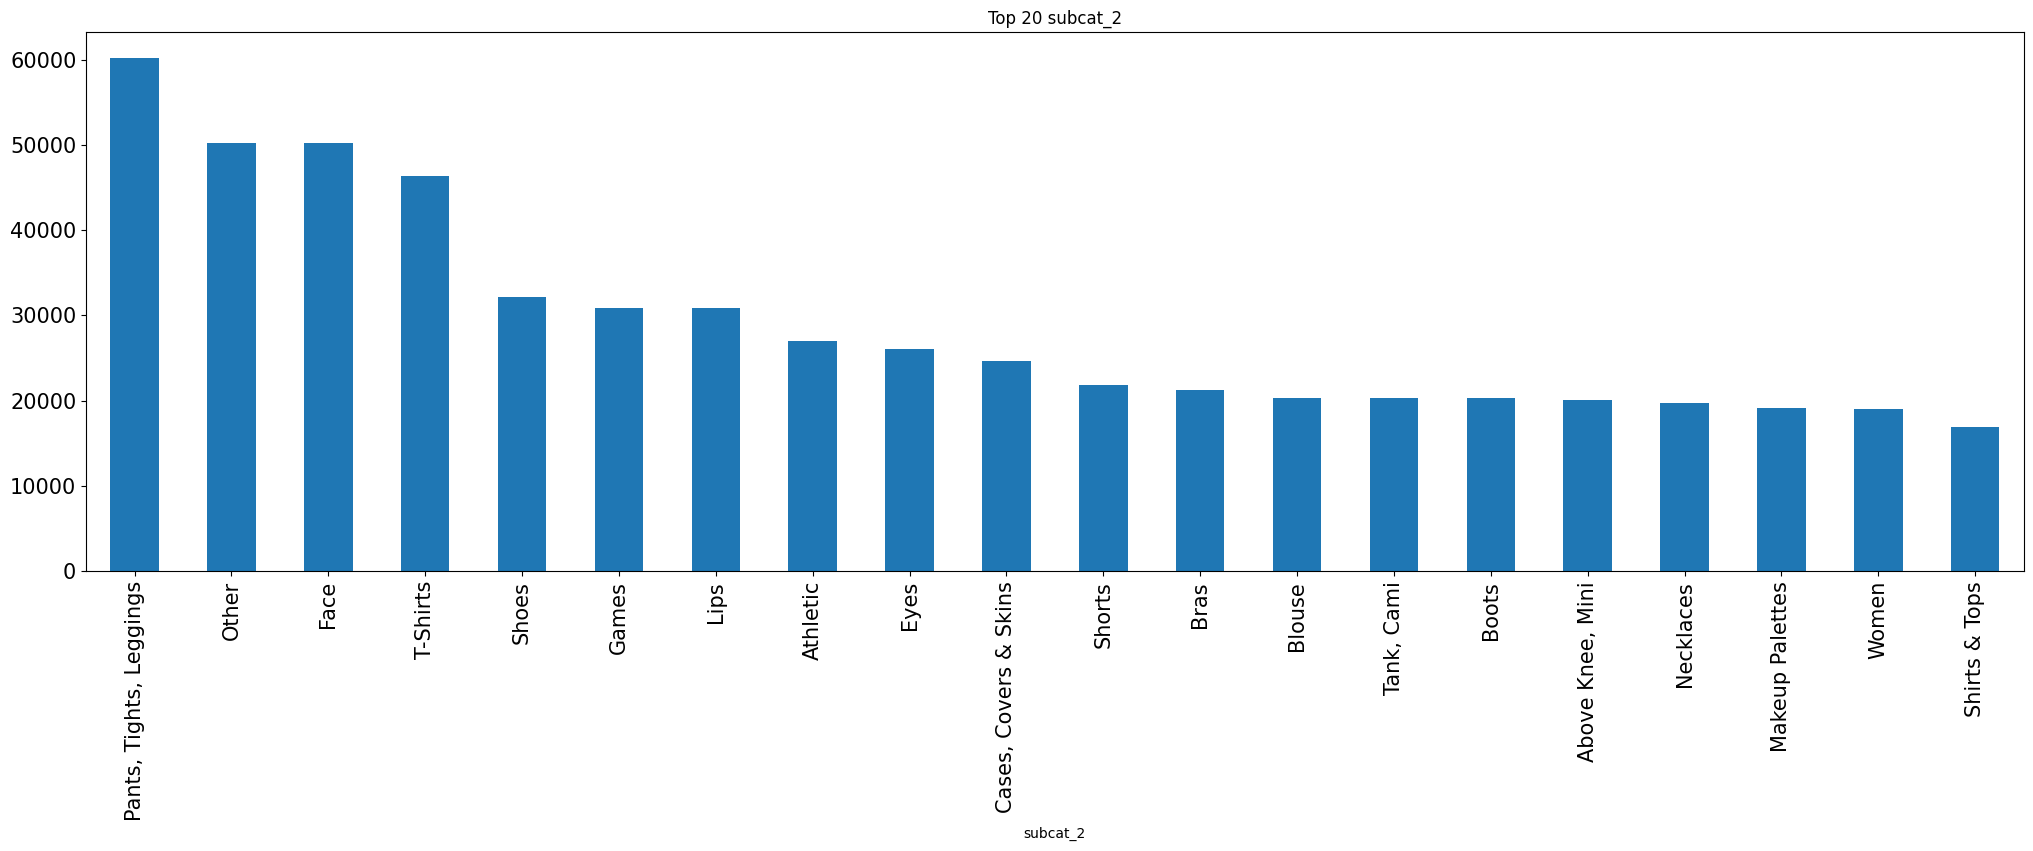

In [32]:
train_df['subcat_2'].value_counts()[:20].plot(kind='bar', figsize=(25,7), title="Top 20 subcat_2", fontsize=15)

As suspected earlier from the brand names, most of the products are seen to belong to the apparels category that too for women. Only ~6000 categories are missing ('No Label' data). As the number of missing categories is very less, I don't think doing some feature engineering to fill them with some 'guessed' category is worth it. We can keep it as No Labeled data and see how our model is performing.

From the above graph we can see that there is a little difference in the distribution of the log prices for every general category. Relying solely on the general category to make a price prediction will not be a good idea. We should use it in combination of other categories features.

In [35]:
train_df.columns

Index(['train_id', 'name', 'item_condition_id', 'category_name', 'brand_name',
       'price', 'shipping', 'item_description', 'log_prices', 'general_cat',
       'subcat_1', 'subcat_2'],
      dtype='object')

In [36]:
# Correlation
# pointbiserialr correlation is used when we want to calculate the correlation between a nominal data and continuous data.
from scipy.stats import pointbiserialr
pbc_condition = pointbiserialr(train_df['item_condition_id'], train_df['log_prices'])
pbc_shipping = pointbiserialr(train_df['shipping'], train_df['log_prices'])
print("item_condition -> log_prices correlation=", pbc_condition[0])
print("shipping -> log_prices correlation=   ", pbc_shipping[0])

item_condition -> log_prices correlation= -0.0020731146530349504
shipping -> log_prices correlation=    -0.22973782030050915


We can see that the item condition has a very poor correlation with the target variable.   

This was also evident when we saw the distribution of each category as per the prices. However, we should not discard this feature, because logically the item condition does affect the price of the product. It is just that it should not be solely used for predicting the price.   

It would be meaningful to use it in combination with other features, most logically of which is the brand name and the item category. This is because a worn out iPhone X would still cost a couple 100 dollars more than a totally new Micromax phone. Or a Laptop in 'fair' condition would still cost more than a new Nike T-shirt!   

Shipping does have some negative correlation with the target variable.

#### 8. More EDA

In [37]:
def fill_missing_values(df):
    """
    Description:
    Filling null values in all columns.

    Input: Dataframe with null values
    Output: Dataframe with no null values
    """
    df['name'].fillna('unk_name', inplace=True)
    df['category_name'].fillna('unk_cat', inplace=True)
    df['brand_name'].fillna('unk_brand', inplace=True)
    df['item_description'].fillna('unk_descr', inplace=True)
    return df

In [38]:
train_df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,log_prices,general_cat,subcat_1,subcat_2
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,2.397895,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,3.970292,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,2.397895,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,3.583519,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,3.806662,Women,Jewelry,Necklaces


In [39]:
import re
import string

def decontract_text(phrase):
    """
    This utility funciton will be used as a part of preprocessing the text.
    It will expand the contracted words. For eg: won't -> will not, I'm -> I am.
    """
    phrase = str(phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase


def preprocess_descriptive_text_column(text_data):
    """
    Description:
    This function will process the text data.

    Input: original strings [in list form]
    Output: processed strings [in list form]
    """
    # https://gist.github.com/sebleier/554280
    # we are removing the negative words from the stop words list: 'no', 'nor', 'not', 'shouldn't, won't, etc.
    stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
                "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
                'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
                'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
                'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
                'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
                'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
                'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
                'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
                'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
                's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
                've', 'y']

    processed_text = []
    for sentance in tqdm(text_data):
        sent = decontract_text(sentance)
        sent = sent.replace('\r', ' ')
        sent = sent.replace('\n', ' ')
        sent = sent.replace('\"', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        # https://gist.github.com/sebleier/554280
        sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
        processed_text.append(sent.lower().strip())
    return np.array(processed_text)

In [40]:
# inspired from https://www.kaggle.com/gspmoreira/cnn-glove-single-model-private-lb-0-41117-35th
def concat_categories(x):
        return set(x.values)

def brand_guesser(df):
    """
    Description:
    This function is used to guess the missing brand name.
    It will check for an existing brand name mentioned in the item name section. 
    We want out guess to be as close to actual as possible, \
    hence we will also check the category of the brand name that is guessed with the already mentioned category of that product. 
    If the category matches, then only we will fill that guessed brand name.

    Inputs: dataframe with missing brand names
    Output: dataframe with filled brand names
    """
    existing_brands = df[df['brand_name'] != 'unk_brand']['brand_name'].unique()
    brand_names_categories = dict(df[df['brand_name'] != 'unk_brand'][['brand_name','category_name']].astype('str').groupby('brand_name').agg(concat_categories).reset_index().values.tolist())
    # In the above line, we are creating dictionary of brand name->category, wherever the brand name is missing.
    # This will be helpful to us during guessing the missing brand names.
    filled_brands = []
    for row in tqdm(df[['brand_name','name','category_name']].values):
        found=False
        if row[0]=='unk_brand':
            for brand in existing_brands:
                if brand in row[1] and row[2] in brand_names_categories[brand] :
                    filled_brands.append(brand)
                    found=True
                    break
            if not found:
                filled_brands.append('unk_brand')
        else:
            filled_brands.append(row[0])

    df['brand_name']=filled_brands
    return df

In [41]:
def split_text(text):
    if text=='unk_cat':
        return ["No Label", "No Label", "No Label"]
    return text.split("/")

def split_categories(df):
    """
    Desription:
    This function separated the categories into its three parts. 
    Main category, Sub-category 1 and Sub-category 2
    Then we will remove the original category_name field.

    Input: Dataframe
    Output: Dataframe
    """
    df['general_cat'], df['subcat_1'], df['subcat_2'] = zip(*df['category_name'].apply(lambda x: split_text(x)))
    df = df.drop('category_name', axis=1)
    return df
     

In [42]:
train_df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,log_prices,general_cat,subcat_1,subcat_2
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,2.397895,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,3.970292,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,2.397895,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,3.583519,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,3.806662,Women,Jewelry,Necklaces


In [43]:
train_df = fill_missing_values(train_df)

In [44]:
train_df['name'] = preprocess_descriptive_text_column(train_df['name'].values)

  0%|          | 0/1482535 [00:00<?, ?it/s]

In [45]:
train_df['brand_name'] = train_df['brand_name'].apply(lambda x: str(x).lower())

In [46]:
train_df = brand_guesser(train_df)

  0%|          | 0/1482535 [00:00<?, ?it/s]

In [47]:
train_df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,log_prices,general_cat,subcat_1,subcat_2
0,0,mlb cincinnati reds shirt size xl,3,Men/Tops/T-shirts,mlb,10.0,1,No description yet,2.397895,Men,Tops,T-shirts
1,1,razer blackwidow chroma keyboard,3,Electronics/Computers & Tablets/Components & P...,razer,52.0,0,This keyboard is in great condition and works ...,3.970292,Electronics,Computers & Tablets,Components & Parts
2,2,ava viv blouse,1,Women/Tops & Blouses/Blouse,target,10.0,1,Adorable top with a hint of lace and a key hol...,2.397895,Women,Tops & Blouses,Blouse
3,3,leather horse statues,1,Home/Home Décor/Home Décor Accents,unk_brand,35.0,1,New with tags. Leather horses. Retail for [rm]...,3.583519,Home,Home Décor,Home Décor Accents
4,4,24k gold plated rose,1,Women/Jewelry/Necklaces,unk_brand,44.0,0,Complete with certificate of authenticity,3.806662,Women,Jewelry,Necklaces


In [49]:
train_df['brand_name'].nunique()

4810